In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.infer.autoguide import AutoNormal
from pyro.nn.module import PyroParam, PyroModule, PyroSample
from pyro.contrib.gp import Parameterized
plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
co2_df = pd.read_csv("/mnt/dl/machine_learning_dataset/atmospheric_co2_mauna_loa/monthly_in_situ_co2_mlo.csv",
                     skiprows=57)

In [3]:
co2_df

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,03,21259,1958.2027,315.71,314.44,316.19,314.91,315.71,314.44,MLO
...,...,...,...,...,...,...,...,...,...,...,...
789,2023,08,45153,2023.6219,419.56,421.11,419.58,421.18,419.56,421.11,MLO
790,2023,09,45184,2023.7068,418.07,421.57,417.96,421.48,418.07,421.57,MLO
791,2023,10,45214,2023.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
792,2023,11,45245,2023.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [4]:
co2_df.columns

Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally', ' Sta'],
      dtype='object')

In [5]:
co2_df = co2_df.loc[2:,['  Yr', ' Mn', '     CO2',]]

In [6]:
new_cols = list(map(lambda x: x.strip(), co2_df.columns))

In [7]:
new_cols 

['Yr', 'Mn', 'CO2']

In [8]:
co2_df = co2_df.rename(columns=dict(zip(co2_df.columns, new_cols)))

In [9]:
co2_df

,Yr,Mn,CO2
2,1958,01,-99.99
3,1958,02,-99.99
4,1958,03,315.71
5,1958,04,317.45
6,1958,05,317.51
...,...,...,...
789,2023,08,419.56
790,2023,09,418.07
791,2023,10,-99.99
792,2023,11,-99.99


In [10]:
co2_df.Yr = co2_df.Yr.astype(int)
co2_df.Mn = co2_df.Mn.astype(int)
co2_df.CO2 = co2_df.CO2.astype(float)

In [11]:
# Drop Missing
data = co2_df.copy()
data = data[data["CO2"] != -99.99]

In [12]:
data

,Yr,Mn,CO2
4,1958,3,315.71
5,1958,4,317.45
6,1958,5,317.51
8,1958,7,315.87
9,1958,8,314.93
...,...,...,...
786,2023,5,423.78
787,2023,6,423.39
788,2023,7,421.62
789,2023,8,419.56


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 4 to 790
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      782 non-null    int64  
 1   Mn      782 non-null    int64  
 2   CO2     782 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 24.4 KB


In [14]:
data["date"] = data.apply(lambda x: f"{int(x['Yr'])}-{int(x['Mn']):02d}", axis=1)

In [15]:
data

,Yr,Mn,CO2,date
4,1958,3,315.71,1958-03
5,1958,4,317.45,1958-04
6,1958,5,317.51,1958-05
8,1958,7,315.87,1958-07
9,1958,8,314.93,1958-08
...,...,...,...,...
786,2023,5,423.78,2023-05
787,2023,6,423.39,2023-06
788,2023,7,421.62,2023-07
789,2023,8,419.56,2023-08


/tmp/ipykernel_2021/263896264.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels()[::14], rotation=90)


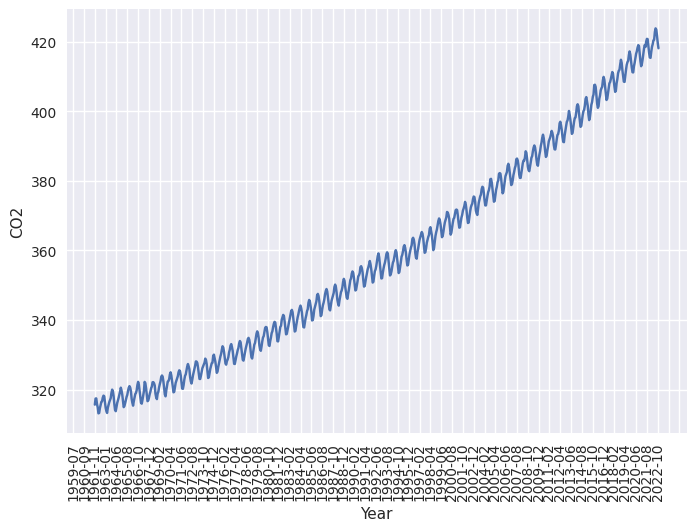

In [16]:
fig, ax = plt.subplots()
ax.plot(data["date"], data["CO2"])
ax.set_xlabel("Year")
ax.set_ylabel("CO2")
ax.set_xticklabels(ax.get_xticklabels()[::14], rotation=90)
locator = mpl.ticker.MultipleLocator(15)
ax.xaxis.set_major_locator(locator)

In [17]:
x = data.date.values.tolist()
y = torch.tensor(data.CO2.values).float()

In [18]:
ytrain = y.cuda()

In [19]:
yvar, ymean = torch.var_mean(ytrain)
yvar, ymean

(tensor(962.1697, device='cuda:0'), tensor(358.5257, device='cuda:0'))

In [20]:
ytrain.std()

tensor(31.0189, device='cuda:0')

In [21]:
ytrain_norm = (ytrain  - ymean) / yvar.sqrt()

In [22]:
ytrain_norm.mean(), ytrain_norm.std()

(tensor(4.8293e-07, device='cuda:0'), tensor(1., device='cuda:0'))

In [23]:
ytrain_norm[::100]

tensor([-1.3803, -1.2091, -0.8126, -0.5199, -0.1204,  0.4205,  0.8229,  1.4815],
       device='cuda:0')

In [24]:
class STSNet(PyroModule):
    
    def __init__(self, S, device=torch.device("cpu")):
        super().__init__()
        # self.z = PyroSample(lambda self: dist.Normal(torch.tensor([0.0] * 2), torch.tensor(1.0)).to_event(1) )
        self.z = PyroSample(dist.Normal(torch.tensor([0.0] * 2), torch.tensor(1.0)).to_event(1) )
        self.μ = PyroSample(lambda self: dist.LogNormal(0, 1.))
        self.δ = PyroSample(lambda self: dist.LogNormal(0, 1.))
        self.ϵ = PyroSample(lambda self: dist.LogNormal(0, 1.))
        
        self.transition_matrix = torch.tensor([[1., 1.], [0, 1]], device=device)
        self.obs_matrix = torch.tensor([1., 0], device=device)
        
        self.device = device
    
    def forward(self, y, values):
        # data_plate = pyro.plate("data", len(y))
        z = self.z
        for t in range(len(y)) :
            zmean = self.transition_matrix @ z.to(self.transition_matrix.device)
            
            z = pyro.sample(f"z_{t}", dist.Normal(zmean, torch.tensor([self.μ, self.δ], device=self.device)).to_event(1))
            ymean = self.obs_matrix @ z 
            if values is None:
                obs = pyro.sample(f"y_{t}", dist.Normal(ymean, self.ϵ), obs=y[t])
            else:
                obs = pyro.sample(f"y_{t}", dist.Normal(ymean, self.ϵ))
                
            if values is not None and isinstance(values, list):
                values.append(obs.item())

class CO2STS(PyroModule):
    
    def __init__(self, net, y):
        super().__init__()
        self.net = net
        self.y = torch.as_tensor(y)#[:2]

    def model(self, training=True):
        # pyro.module("net", self)
        self.values = None
        if not training:
            self.values = []
        self.net(self.y, self.values)
        
        

In [ ]:
pyro.clear_param_store()
pyro.set_rng_seed(10)
net = STSNet(S=12, device=torch.device("cuda:0")).cuda()

co2_model = CO2STS(net, y=ytrain_norm)
model = (
        # co2_model.model
        poutine.block(co2_model.model, 
                      # expose_fn=lambda x: "z" not in x["name"] 
                    #   expose_fn=expose_fn,
                    expose_fn=lambda x: "z_" not in x["name"]
                      )
        )
def init_loc_fn(x):
    print(x)
    if 'net.z' in x["name"]:
      print("one")
      return torch.tensor([-1.5, 0.01])
    return torch.tensor(0.001)
  
guide = AutoNormal(model, init_loc_fn=init_loc_fn, init_scale=10.)

In [ ]:
with torch.no_grad():
    with poutine.block(), poutine.trace(param_only=True) as param_capture:
        guide()
        

params = list([pyro.param(name).unconstrained() for name in param_capture.trace])
loss_fn =  infer.Trace_ELBO().differentiable_loss
optimizer = torch.optim.Adam(params, lr=1e-4,)
print(list(pyro.get_param_store().items()))

In [ ]:
pyro.param('AutoNormal.scales.net.z', torch.tensor([1.0, 1.0]))

In [ ]:
pyro.get_param_store().__setitem__('AutoNormal.scales.net.z',  torch.tensor([1.0, 1.0]))

In [ ]:
pyro.param('AutoNormal.scales.net.z')

In [ ]:
guide_trace = poutine.trace(guide).get_trace()

In [ ]:
guide_trace.nodes

In [ ]:
guide_trace.compute_log_prob()

In [ ]:
guide_trace.nodes

In [ ]:
guide_trace.log_prob_sum()

In [ ]:
model_trace = poutine.trace( poutine.replay(co2_model.model, trace=guide_trace)).get_trace() 

In [ ]:
model_trace.compute_log_prob()

In [ ]:
model_trace.nodes

In [ ]:
model_trace.log_prob_sum()

In [41]:
def run():
    pyro.clear_param_store()
    pyro.set_rng_seed(10)
    net = STSNet(S=12, device=torch.device("cuda:0")).cuda()

    co2_model = CO2STS(net, y=ytrain_norm)
    model = (
            poutine.block(co2_model.model, 
                        expose_fn=lambda x: "z_" not in x["name"]
                        )
            )
    def init_loc_fn(x):
        if 'net.z' in x["name"]:
            return torch.tensor([-1.5, 0.01])
        return torch.tensor(0.001)
    
    guide = AutoNormal(model, init_loc_fn=init_loc_fn, init_scale=10.)
    
    with torch.no_grad():
        with poutine.block(), poutine.trace(param_only=True) as param_capture:
            guide()
    
    params = list([pyro.param(name).unconstrained() for name in param_capture.trace])
    optimizer = torch.optim.Adam(params, lr=1e-2,)
    print(list(pyro.get_param_store().items()))
    pyro.get_param_store().__setitem__('AutoNormal.scales.net.z',  torch.tensor([1.0, 1.0]))
    
    def train():
        guide_trace = poutine.trace(guide).get_trace()
        guide_trace.compute_log_prob()
        
        
        
        model_trace = poutine.trace( poutine.replay(co2_model.model, trace=guide_trace)).get_trace() 
        model_trace.compute_log_prob()
        
        elbo_loss = 0
        
        for site in model_trace.nodes:
            if model_trace.nodes[site]["type"] != "sample":
                continue
            print(elbo_loss, model_trace.nodes[site]["name"], model_trace.nodes[site]["log_prob"])
            
            # elbo_loss += model_trace.nodes[site]["log_prob"]
        pass
    
    return train
                
    

In [42]:
losses = []
runner = run()
for i in range(8):
    print(i)
    loss = runner()
    break
#     optimizer.zero_grad()
#     torch.nn.utils.clip_grad_norm_(params, 10.)
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.detach().item())

[('AutoNormal.locs.net.z', Parameter containing:
tensor([-1.5000,  0.0100], requires_grad=True)), ('AutoNormal.scales.net.z', tensor([10., 10.], grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.μ', Parameter containing:
tensor(-6.9078, requires_grad=True)), ('AutoNormal.scales.net.μ', tensor(10., grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.δ', Parameter containing:
tensor(-6.9078, requires_grad=True)), ('AutoNormal.scales.net.δ', tensor(10., grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.ε', Parameter containing:
tensor(-6.9078, requires_grad=True)), ('AutoNormal.scales.net.ε', tensor(10., grad_fn=<SoftplusBackward0>))]
0
0 net.z tensor(-3.9154, grad_fn=<SumBackward1>)
0 net.μ tensor(-120.3808, grad_fn=<AddBackward0>)
0 net.δ tensor(-159.3417, grad_fn=<AddBackward0>)
0 z_0 tensor(33.4798, device='cuda:0', grad_fn=<SumBackward1>)
0 net.ε tensor(-86.7776, grad_fn=<AddBackward0>)
0 y_0 tensor(-13.0611, device='cuda:0', grad_fn=<SubBackward0>)
0 z_1 tensor(33.4798, devic

In [ ]:
plt.plot(losses)

In [ ]:
losses